In [2]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cv2.ocl.setUseOpenCL(False)

In [24]:
img1 = cv2.imread('SourceImages/stitch_l.png',0)          # queryImage
img2 = cv2.imread('SourceImages/stitch_m.png',0) # trainImage

print(img1.shape)
# Initiate SIFT detector
#orb = cv2.ORB() // for cv3 change this line to be the following line worked 
#http://answers.opencv.org/question/177524/brute-force-matching-with-orb-descriptors/
orb = cv2.ORB_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# print("kp1 is: \n")
# print(kp1[0].pt)
for elements in kp1:
    (x1,y1) = elements.pt
    cv2.circle(img1, (int(x1),int(y1)), 4, (255, 0, 0), 1)   



(912L, 608L)


In [26]:
print(img1.shape)

(912L, 608L)


(-0.5, 607.5, 911.5, -0.5)

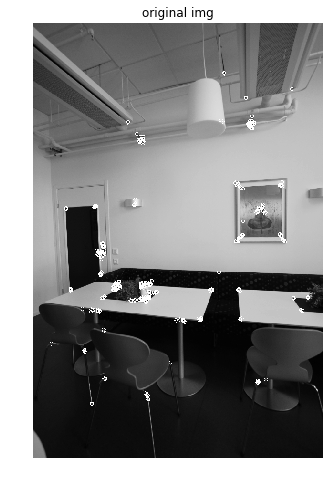

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img1, 'gray')
plt.title('original img')
plt.axis('off')


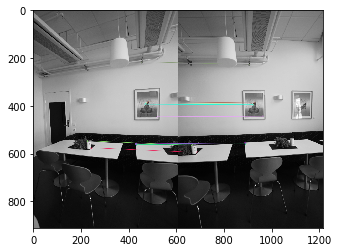

(<matplotlib.image.AxesImage at 0x7e5dd68>, None)

In [5]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
# Match descriptors.
matches = bf.match(des1,des2)  

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)

plt.imshow(img3),plt.show()

In [13]:
def drawMatches(img1, kp1, img2, kp2, matches):
    rows1 = img1.shape[0]
    print("rows1 is "+ str(rows1))
    cols1 = img1.shape[1]
    print("cols1 is "+ str(cols1))
    rows2 = img2.shape[0]
    print("rows2 is "+ str(rows2))
    cols2 = img2.shape[1]
    print("cols2 is "+ str(cols2))

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')
    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])
    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])
     # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
    # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
    # x - columns
    # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt
    # Draw a small circle at both co-ordinates
    # radius 4
    # colour blue
    # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)
    # Draw a line in between the two points
    # thickness = 1
    # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 2)
    # Also return the image if you'd like a copy
    return out




rows1 is 912
cols1 is 608
rows2 is 912
cols2 is 608


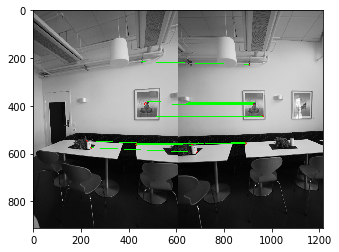

(<matplotlib.image.AxesImage at 0x84ece10>, None)

In [17]:
# cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)
matches = sorted(matches, key = lambda x:x.distance)
img4=drawMatches(img1, kp1, img2, kp2, matches[:10])
plt.imshow(img4),plt.show()

# Brute-Force Matching with SIFT Descriptors and Ratio Test

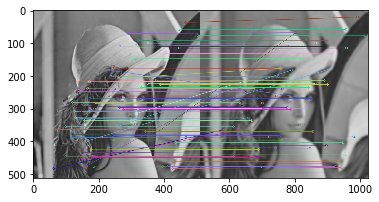

(<matplotlib.image.AxesImage at 0x8791320>, None)

In [49]:
img1 = cv2.imread('SourceImages/p1_01.jpg',0)          # queryImage
img2 = cv2.imread('SourceImages/p1_02.jpg',0) # trainImage
# Initiate SIFT detector

#sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create() # for cv 3.4 you have to use this 

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.imshow(img3),plt.show()



# FLANN based Matcher

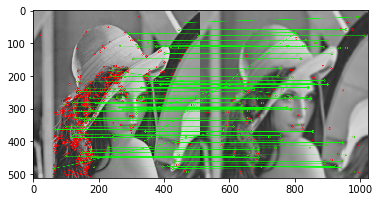

(<matplotlib.image.AxesImage at 0x8dab400>, None)

In [51]:
img1 = cv2.imread('SourceImages/p1_01.jpg',0)          # queryImage
img2 = cv2.imread('SourceImages/p1_02.jpg',0) # trainImage

# Initiate SIFT detector
#sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

(648L, 1152L, 3L)
[[  1.26666667   0.6        -83.33333333]
 [ -0.33333333   1.          66.66666667]]


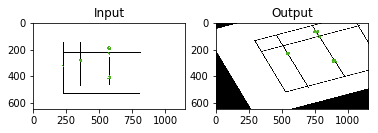

In [60]:
img = cv2.imread('SourceImages/draw.png')
rows,cols,ch = img.shape
print(img.shape)
#print(img[0])

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
# print(pts1)
# print(pts2)

M = cv2.getAffineTransform(pts1,pts2)
print(M)

dst = cv2.warpAffine(img,M,(cols,rows))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()